# Class 2: Big Data Anonymisation

## Introduction

In this class, you will manipulate a synthetic CDR (call data record) phone metadata dataset, that closely mimics real-world data. As we know, people in such datasets are very unique, and knowing a few points of someone's trajectory is most of the time enough to find this person uniquely. Note that this dataset is purely synthetic, and the unicity numbers might not match the numbers shown in class.

In these exercises, you will first compute the _unicity_ of people in the dataset, and see how this unicity decreases with the size of the population. You will then generalise the location and time of the points collected to see how it decreases unicity. Finally, you will perform a more sophisticated attack, that works even when the data is corrupted by noise.

### Loading the data

This week, we will not be using Pandas, as real-world CDR datasets are way too large to fit in a Pandas dataframe. Instead, we will be manipulating raw data using Python structures (namely, lists and dictionaries).

**Dataset description**

This dataset is composed of metadata: every time a person calls (or gets called by) another or sends (or receives) a text message, the time and place is stored in the dataset. In our case, the data is stored as a large text file, with every line describing one event, as:

`user_id antenna_id timestamp`

The `antenna_id` represents the antenna that served the user. These antennas are numbered, and give location information for the user. An additional file gives the mapping from antenna number to geographical locations, with one antenna per line, and each line as:

`antenna_id latitude longitude`

The `timestamp` corresponds to the _hour_ since the beginning of the dataset's data collection.

The specific dataset that you will use contains 50,000 people, over a period of _one week_ in a geography you should be rather familiar with.

**Warning**: this notebook is quite _memory intensive_, and should take around 2 GB of memory when all exercises have been executed. If you have reasons to believe that this might be an issue, we also provide you with a smaller dataset (10,000 users), which shouldn't take more than 550 MB (that's like running two Facebook tabs on Google Chrome).

**Step 1: Python data structure and data loading**

For starters, we will represent the CDR as a list of points, and the geography using a `Numpy` array with $n_{antennas}$ lines and two columns (longitude and latitude).

On a technical note: for simplicity we will use lat-long coordinates as Cartesian coordinates on the Euclidean plane. Note however that this method is not completely accurate, as [distances](https://en.wikipedia.org/wiki/Great-circle_distance) are not [preserved](http://jonisalonen.com/2014/computing-distance-between-coordinates-can-be-simple-and-fast). It works however as a first approximation.

In [1]:
import numpy as np

In [2]:
CDR = []

# TODO: use `CDR_10k.txt` if you want to reduce the memory usage
with open('CDR_50k.txt', 'r') as cdrfile:
    for line in cdrfile:
        user_id, antenna_id, timestamp = map(int, line.split())
        CDR.append((user_id, antenna_id, timestamp))

In [3]:
# First, store the file in a dictionary
antennasdict = {}
with open('uk_antennas.txt', 'r') as antennafile:
    for line in antennafile:
        antenna_id, lat, long = line.split()
        antennasdict[int(antenna_id)] = (float(lat), float(long))

# Define the numpy array, with the correct size (maxkey + 1, as indexing starts at 0)
antennas = np.zeros((max(antennasdict.keys())+1,2))

# Encode information as required
for antenna_id in antennasdict.keys():
    antennas[antenna_id,:] = antennasdict[antenna_id]

# Delete unused information
del antennasdict

**Step 2: Plotting the geography**

Let's have a quick look at what the geographical data tells us about antenna distribution.

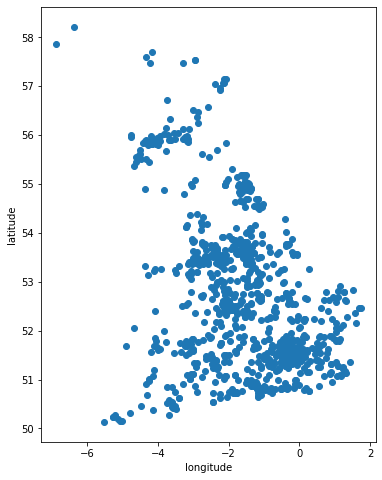

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,8))
plt.scatter(antennas[:,1], antennas[:,0]);
plt.xlabel('longitude')
plt.ylabel('latitude');

Does it look familiar?

**Step 3: The circadian rythms**

Humans are known for their great [behavioural regularity over time](https://en.wikipedia.org/wiki/Circadian_rhythm): we work and do most of our interactions during the day, while nights are much quieter. This can actually be observed in `CDR` data. Let's plot the number of interactions over time.

In [5]:
times = [r[2] for r in CDR]

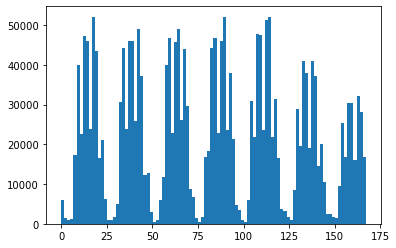

In [6]:
# this histogram displays the circadian rythms of human life
plt.hist(times, 100);

## Exercise 1 | Computing unicity

In the first step of this exercise, you will create a function to estimate the unicity of a dataset. Recall that the unicity $\varepsilon_k$ _estimates_ the fraction of users that are unique for $k$ random points.

**Algorithm.**
The procedure we will use to compute the unicity $\varepsilon_k$ is as follows (see [algorithm 2 in this paper](https://science.sciencemag.org/content/sci/suppl/2015/01/28/347.6221.536.DC1/deMontjoye.SM.pdf) for reference):
1. Select a random sample of the population $u_1, \dots, u_m$.
2. For each user $u_i$ in this sample, select $k$ points at random: $(p_{i,1}, \dots, p_{i,k})$.
3. Compute, for each user $u_i$, whether they are unique according to $(p_{i,1}, \dots, p_{i,k})$ over the _full_ dataset.

**Data structures.**
The algorithm requires to be able to quickly access all of a user's points, as well as check easily whether a set of points is unique in a population. The data structures that we propose to use in this case are a couple of _dictionaries_ named `u2p` (_user to point_) and `p2u` (_point to user_):
- `u2p` maps each user ID to the _list_ of its points: `[(antenna1, time1), ..., (antennaL, timeL)]`
- `p2u` maps each point to the _set_ of users who share this point: `{user1, ..., userK}`

This way, one can quickly compute how many users share a set of points $(p_1, ..., p_k)$ by computing the size of the _intersection_ $\bigcap_{1 \leq i \leq k} \mathsf{p2u}[p_i]$.

The first exercise is to create a function to estimate unicity.

**Step 1 _(action required)_** : create functions to extract the `p2u` and `u2p` data structures from the data `CDR`.

_hint: `collections.defaultdict` could be useful._

In [7]:
import collections

In [8]:
def compute_u2p_p2u( CDR ):
    '''Returns a tuple (u2p, p2u) computed from the list of points CDR.
       u2p maps each userid in CDR to a list of points.
       p2u maps each point to a set of user ids.'''
    
    # YOUR CODE HERE
    pass

    # ANSWER
    u2p = collections.defaultdict(list)
    p2u = collections.defaultdict(set)
    for userid, antenna_id, timestamp in CDR:
        point = (antenna_id, timestamp)
        u2p[userid].append(point)
        p2u[point].add(userid)
    return u2p, p2u

_Double-check:_ Verify that the code you have written is correct, by checking whether the structures contain compatible information (i.e. every point in `u2p[u]` has `u` in its `p2u` entry, and reciprocally).

In [9]:
u2p, p2u = compute_u2p_p2u(CDR)

error = 0
for user in u2p.keys():
    for p in u2p[user]:
        if user not in p2u[p]:
            error += 1
            print('Point %d belongs to user %s\'s u2p, but not reciprocally' % (p, user))
for point in p2u.keys():
    for u in p2u[point]:
        if point not in u2p[u]:
            error += 1
            print('User %d belongs to point %s\'s p2u, but not reciprocally' % (u, point))
if error:
    print('There were %d errors' % error)
else:
    print('It seems to work fine!')

It seems to work fine!


Using `u2p`, let's confirm we have the right number of users in the dataset.

In [10]:
print('The dataset contains %d users!' % len(u2p.keys()))

The dataset contains 50000 users!


**Step 2 _(action required)_** : using the `u2p` and `p2u` structures, write a function that computes the unicity for `k` points.

_Hint: use `np.random.choice` to randomly select users and points (with or without replacement?)_

In [11]:
def unicity(u2p, p2u, k, nsample=10000):
    '''Computes the unicity for k points of the CDR dataset represented by (u2p, p2u).
       The argument `nsample` describes the size of the sample of users to use in step 1.
       Returns a number between 0 and 1 (the fraction of users unique with k random points).'''
    
    # YOUR CODE HERE
    pass

    # ANSWER
    # step 1)
    users = np.random.choice(list(u2p.keys()), size=(nsample,), replace=False)
    nunique = 0.0
    for u in users:
        # step 2)
        allpoints = u2p[u]
        point_indexes = np.random.choice(len(allpoints), size=(k,), replace=False)
        points = [allpoints[i] for i in point_indexes]
        # step 3)
        userset = p2u[points[0]]
        for p in points[1:]:
            userset = userset.intersection(p2u[p])
        nunique += (len(userset)==1)
    # return the proportion
    return nunique/nsample

**Step 3:** compute the unicity for $k=2,3,4,5,6$. What do you observe?

In [12]:
for k in range(2,7):
    print('k=%d\te%d = %.3f' % (k,k,unicity(u2p, p2u, k)))

k=2	e2 = 0.660
k=3	e3 = 0.958
k=4	e4 = 0.995
k=5	e5 = 1.000
k=6	e6 = 1.000


Did you obtain $\varepsilon_2 \approx 0.66$ and $\varepsilon_4 \approx 0.99$?

**Step 4 _(action required)_**: Are the numbers higher or lower than you expected? What if you compare with the class?

_Your answer here._

`SAMPLE ANSWER`

These numbers are really high, and higher than what we see in the class. The main reason for this is that the population is _much smaller_: 50k, rather than 1.5 million. In a population that is 30 times smaller, over the geography of the UK (although the geography of the course's dataset is potentially different), people are much more likely to be unique.

## Exercise 2 | Scaling of unicity

One of the main criticisms about the unicity metric is that it's unclear how it evolves with larger populations, and current research has only used "small" datasets, subsamples of a larger population. Potentially, the unicity of a large population could be very small.

In this second exercise, you will use your `unicity` function to compute unicity on populations of growing size, to see how unicity decreases with population size.

**Step 1 _(action required)_**: modify your `unicity` function by adding a `populationsize` argument. The first step of the algorithm should be to sample a set of users of size `populationsize`, and treat it as the "full" population to compute unicity on (in steps 1 and 3). That is, your function will first select a subset of the population, then you can reuse your code from `unicity`, which selects a sample of size `nsample` from which to estimate the unicity. Make sure you understand how these two parameters are different (`populationsize` is the size of the sample used to represent a smaller population, while `nsample` is a computational parameter, giving the size of the user sample used in the computation of unicity).

_Hint: you can restrict the population in step 3) of the unicity algorithm by adding the intersection with the population._

In [13]:
def unicity_population(u2p, p2u, k, populationsize, nsample=10000):
    '''Computes the unicity for k points of the a subset of the CDR dataset represented by (u2p, p2u).
       The argument `nsample` describes the size of the sample of users to use in step 1.
       Returns a number between 0 and 1 (the fraction of users unique with k random points).'''
    
    # YOUR CODE HERE
    pass

    # ANSWER
    # step 0)
    population = np.random.choice(list(u2p.keys()), size=(populationsize,), replace=False)
    # step 1)
    if nsample > populationsize:
        nsample = populationsize
    users = np.random.choice(population, size=(nsample,), replace=False)
    population = set(population)
    nunique = 0.0
    for u in users:
        # step 2)
        allpoints = u2p[u]
        point_indexes = np.random.choice(len(allpoints), size=(k,), replace=False)
        points = [allpoints[i] for i in point_indexes]
        # step 3)
        userset = p2u[points[0]]
        for p in points[1:]:
            userset = userset.intersection(p2u[p])
        userset = userset.intersection(population)
        nunique += (len(userset)==1)
    # return the proportion
    return nunique/nsample

_Double-check: compute the unicity with sample size = 50000 (or 10000, the full population size), and see if you do get approximately the same values._

In [14]:
# ANSWER
for k in range(2,7):
    print('k=%d\te%d = %.3f' % (k,k,unicity_population(u2p, p2u, k, len(u2p))))

k=2	e2 = 0.664
k=3	e3 = 0.956
k=4	e4 = 0.995
k=5	e5 = 1.000
k=6	e6 = 1.000


**Step 2**: Let's compute the unicity of datasets of increasing size.

In [15]:
# if you are using CDR_10k instead, comment out the last point
popsize = [100, 5000, 10000, 50000]
krange  = range(2, 7)
unicvs  = {k:np.zeros((len(popsize),)) for k in krange}

for k in krange:
    for i, p in enumerate(popsize):
        unicvs[k][i] = unicity_population(u2p, p2u, k, p)

**Step 3**: let's plot the unicity, using `matplotlib`. What do you think of the plot? Does unicity decrease quickly?

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

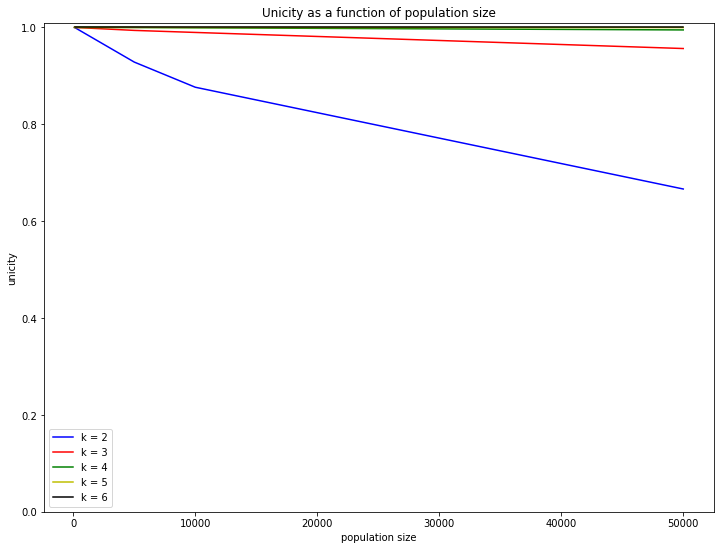

In [17]:
plt.figure(figsize=(12,9))

colors = {2:'b', 3:'r', 4:'g', 5:'y', 6:'k'}
for k in krange:
    plt.plot(popsize, unicvs[k], label='k = %d' % k, color=colors[k])

plt.title('Unicity as a function of population size')
plt.xlabel('population size')
plt.ylabel('unicity')
plt.ylim([0,1.01])
plt.legend(loc=3);

**Step 4 _(action required)_**: What does this plot tell you about unicity? Does it seem to decrease fast?

_Your answer here._

`SAMPLE ANSWER`

Unicity is **convex**, and decreases rather slowly with population size. Moreover, even if 2 points are not great to identify you, 4 points are more than sufficient.

## Exercise 3 | Generalisation

In this exercise, you will decrease the precision of the locations and times in the CDR dataset, and see how this affects unicity. For this, you will implement a function `generalise(CDR, spatial_res, temporal_res)` that returns another CDR list, where locations and times have been generalised to some resolution (`spatial_res`, `temporal_res`).

**Algorithm**: 
- To aggregate _spatially_, we will use a _clustering_ algorithm ($k-$means) that aggregates antennas in $k$ clusters. We will define $k$ as the number of antennas divided by `spatial_res`, such that on average, every cluster will contain `spatial_res` antennas.
- To aggregate _temporally_, replace each time $t$ (which is an integer corresponding to an hour since the beginning of the dataset collection) by $t~//~\mathsf{temporal\_res}$ (where // denotes the integer division). For example, with $\mathsf{temporal\_res} = 3$ the timestamps `[1,2,3,4,5,6,7,8,9,10]` would become `[0,0,1,1,1,2,2,2,3,3]`.

**Step 1**: We provide you with the `spatial_aggregator` function, that returns a dictionary mapping `antenna_id` to the cluster (aggregated antenna) it is part of. The spatial aggregation procedure of the `generalise` function will thus replace antennas by their cluster. We advise you to look at the code, just to see what it does (since these are useful functions).

In [18]:
# clustering provided by the scipy library
import scipy.cluster as scc

def spatial_aggregator(antennas, spatial_res):
    '''Returns a dictionary mapping antennas to cluster ("super antenna")'''

    # spatial_res is defined as number_of_points / number_of_clusters
    n_clusters = antennas.shape[0] // spatial_res

    # apply K-means to find the centroids :-)
    centroids, quality = scc.vq.kmeans(antennas, n_clusters)

    # retrieve the mapping antenna --> centroid (cluster)
    clusters, _ = scc.vq.vq(antennas, centroids)

    # transform this into a dictionary, to return
    return {i:clusters[i] for i in range(antennas.shape[0])}

**Step 2**: Plot the clusters resulting from the spatial aggregation procedure to check if you see what it does.

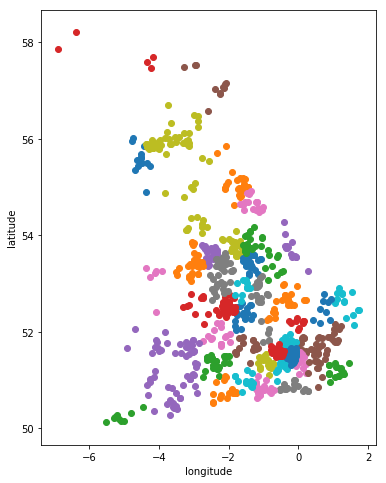

In [19]:
spatial_res = 20 # YOUR CHOICE HERE

antennas_to_clusters = spatial_aggregator(antennas, spatial_res)

clusters = collections.defaultdict(list)

for antenna_id, cl in antennas_to_clusters.items():
    clusters[cl].append(antenna_id)

plt.figure(figsize=(6,8))
for cl, antenna_ids in clusters.items():
    plt.scatter(antennas[antenna_ids,1], antennas[antenna_ids,0])

plt.xlabel('longitude')
plt.ylabel('latitude');

**Step 3 _(action required)_**: Implement the generalisation algorithm in the `generalise` function, using the `antenna_to_cluster` spatial generalisation provided, and the algorithm we suggested above. Your code must return a new `CDR` list.

In [20]:
def generalise(CDR, antennas, spatial_res, temporal_res):
    '''Generalises the CDR given as first argument to some spatial
       and temporal resolution (both integers > 0).
       This uses the `antennas` argument for geographical information on antennas.
       Returns a new CDR list, leaving the original untouched'''

    # define the mapping to cluster
    antenna_to_cluster = spatial_aggregator(antennas, spatial_res)
    
    # YOUR CODE HERE
    pass

    # ANSWER
    new_CDR = []
    for u, p, t in CDR:
        new_CDR.append( (u, antenna_to_cluster[p], t//temporal_res) )
    
    return new_CDR

**Step 4**: Choose some values of the resolution, and compute the generalised CDR, as well as the corresponding `u2p` and `p2u`.

In [21]:
temporal_res = 3
spatial_res  = 3

CDR_gen = generalise(CDR, antennas, spatial_res, temporal_res)

In [22]:
u2p_gen, p2u_gen = compute_u2p_p2u(CDR_gen)

**Step 5**: compute the unicity of the dataset after generalisation (using the parameters defined earlier).

In [23]:
for k in range(2,7):
    print('k=%d\te%d = %.3f' % (k,k,unicity(u2p_gen, p2u_gen, k, len(u2p))))

k=2	e2 = 0.080
k=3	e3 = 0.365
k=4	e4 = 0.631
k=5	e5 = 0.801
k=6	e6 = 0.892


**Step 6 _(action required)_**: So what do you think? Does generalisation really protect you significantly?

_Your answer here._

`SAMPLE ANSWER`

Generalisation _does_ reduce the effectiveness of the attack: 2 points are clearly not enough to consistently identify someone $(\varepsilon_2 \approx 10\%)$. However, even if it is harder to identify someone, adding some more points makes the unicity attack succeed again. For instance, using 6 points leads to a unicity of about 90%. Thus it's just a matter of collecting _a few more points_.

## (Optional) Exercise 4 | Robustness to noise

In this last exercise, you will study how resilient unicity is to uncertainty, in this case spatial uncertainty. For instance, it is common that you know someone's rough location, but not which exact antenna they are using - they could be using any _neighbouring_ antenna. We will assume that the dataset contains the truth, and that the attacker's knowledge is imprecise. Thus, you will have to adapt the way unicity is computed by considering not only users that were at a point `p = (l,t)`, but also at a neighbouring antenna at the same time `p' = (l', t)`.

But first, we must define what "neighbouring antennas" are.

**Step 1**: Firstly, we process the `antennas` matrix to obtain its [Delaunay Triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation). This allows to define "neighbouring antennas" for each antenna.

In [24]:
import scipy.spatial as scs

triangulation = scs.Delaunay(antennas)

neighbour_antennas = {}
indices, indptr = triangulation.vertex_neighbor_vertices
for k in range(antennas.shape[0]):
    neighbour_antennas[k] = list(indptr[indices[k]:indices[k+1]])

We can visualise the Delaunay triangulation using Scipy's specific function `delaunay_plot_2d`.

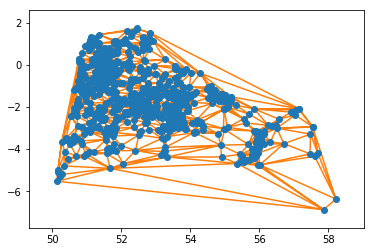

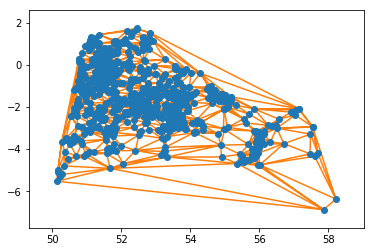

In [25]:
scs.delaunay_plot_2d(triangulation)

Instead of modifying the unicity computation, we can instead adapt the `p2u` structure, so that instead of mapping each point to the set of users in that point, it maps each point to the set of users _in that point and neighbouring points_. This way, we do not need to change the unicity algorithm!

**Step 2 _(action required)_**: Create a modified copy of `compute_u2p_p2u`, that returns a modified `p2u` where each point maps to users in this and neighbouring points.

_Hint: compute `u2p` and `p2u` normally first, then modify a copy of `p2u`._

In [26]:
def compute_u2p_p2u_neighbours( CDR, neighbours ):
    '''Returns a tuple (u2p, p2u) computed from the list of points CDR.
       `neighbours` is a dictionary mapping a point to a list of its neighbors
       u2p maps each userid in CDR to a list of points.
       p2u maps each point to a set of userids in the neighbouring points.'''
    
    u2p, p2u = compute_u2p_p2u( CDR )
    p2u_new = dict(p2u) # creates a copy
    
    # YOUR CODE HERE

    # ANSWER
    for (antenna, timestamp) in list(p2u.keys()):
        # for each neighbour of this antenna
        p2u[(antenna, timestamp)] = set(p2u[(antenna, timestamp)])
        for neighbour in neighbours[ antenna ]:
            # add to the set all users in neighbouring point
            p2u_new[(antenna, timestamp)].update( p2u[(neighbour, timestamp)] )
    
    return u2p, p2u_new

**Step 3**: Use this function to compute the unicity of the population with imprecise information.

In [27]:
u2p_n, p2u_n = compute_u2p_p2u_neighbours( CDR, neighbour_antennas )

In [28]:
for k in range(2,7):
    print('k=%d\te%d = %.3f' % (k,k,unicity(u2p_n, p2u_n, k, len(u2p))))

k=2	e2 = 0.069
k=3	e3 = 0.396
k=4	e4 = 0.750
k=5	e5 = 0.933
k=6	e6 = 0.982


Did you obtain $\varepsilon_5 \approx 0.93$?

**Step 4 _(no action required)_**: What do you think? Is the unicity attack still successful?

_Your answer here._

`SAMPLE ANSWER`

The results are comparable to generalisation for smaller values of $p$, but adding more points makes the attack _much_ more successful. This goes to show that the unicity attack is actually very robust to imprecise knowledge.